# Import libraries and metrics

In [13]:
import json
import numpy as np
import matplotlib.pyplot as plt

RESULTS_PATH = "results/"
CLIENTS_METRICS = "clients.json"

PLOTS_OUT_PATH = "plots/"

with open(RESULTS_PATH + CLIENTS_METRICS, "r") as f:
    clients_metrics = list(map(lambda x: json.loads(x), f.readlines()))


# Results

### Poll Values

In [14]:
poll_values = dict()
poll_values["Favorite Pizza Topping"] = ["Spinach", "Pineapple", "Green peppers", "Black olives", "Extra cheese", "Bacon", "Sausage", "Pepperoni", "Mushrooms", "Onions"]
poll_values["Annual Income Bracket"] = ["<$25,000", "$25,000-$49,999", "$50,000-$74,999", "$75,000-$99,999", "$100,000-$124,999", "$125,000-$149,999", ">=$150,000"]
poll_values["Final Grade in CSD"] = 0.0, 20.0
poll_values["Satisfaction Level with Current Job at NOVA SST"] = 0.0, 10.0

# create dict pollId -> description
descriptions = dict()
for r in clients_metrics:
    if r["metric"] == "poll_create":
        descriptions[r["pollId"]] = r["description"]

## Basic Stats

In [15]:
def diff_values_discrete(description: str):
    # get times true vote differs from noisy vote
    return sum(list(map(lambda r: 0 if int(r["trueVoteValue"]) - int(r["noisyVoteValue"]) == 0 else 1,
                    filter(lambda r: r["metric"] == "poll_vote" and descriptions[r["pollId"]] == description, clients_metrics))))

def diff_values_numeric(description: str):
    # get times true vote differs from noisy vote
    return sum(list(map(lambda r: abs(float(r["trueVoteValue"]) - float(r["noisyVoteValue"])),
                    filter(lambda r: r["metric"] == "poll_vote" and descriptions[r["pollId"]] == description, clients_metrics))))

def epsilon(description: str):
    return float(list(map(lambda r: r["epsilon"],filter(lambda r: r["metric"] == "poll_create" and r["description"] == description, clients_metrics)))[0])

def prob_truth(epsilon: float):
    return np.exp(epsilon) / (np.exp(epsilon) + 1)

def means_numeric(description: str):
    # mean of both true and noisy votes
    return np.mean(list(map(lambda r: float(r["trueVoteValue"]),filter(lambda r: r["metric"] == "poll_vote" and descriptions[r["pollId"]] == description, clients_metrics)))), np.mean(list(map(lambda r: float(r["noisyVoteValue"]),filter(lambda r: r["metric"] == "poll_vote" and descriptions[r["pollId"]] == description, clients_metrics))))

def num_votes(description):
    return int(list(map(lambda r: r["numVotes"],filter(lambda r: r["metric"] == "poll_complete" and descriptions[r["pollId"]]  == description, clients_metrics)))[0])

In [16]:
print("Epsilon Favorite Pizza Topping]: ", epsilon("Favorite Pizza Topping"))
print("Epsilon [Annual Income Bracket]: ", epsilon("Annual Income Bracket"))

print("Epsilon [Final Grade in CSD]: ", epsilon("Final Grade in CSD"))
print("Epsilon [Satisfaction Level with Current Job at NOVA SST]: ", epsilon("Satisfaction Level with Current Job at NOVA SST"))

Epsilon Favorite Pizza Topping]:  1.0
Epsilon [Annual Income Bracket]:  1.0
Epsilon [Final Grade in CSD]:  1.0
Epsilon [Satisfaction Level with Current Job at NOVA SST]:  1.0


In [17]:
print("P(Truth) [Favorite Pizza Topping]: ", prob_truth(epsilon("Favorite Pizza Topping")))
print("P(Truth) [Annual Income Bracket]: ", prob_truth(epsilon("Annual Income Bracket")))

P(Truth) [Favorite Pizza Topping]:  0.7310585786300049
P(Truth) [Annual Income Bracket]:  0.7310585786300049


In [18]:
print("Num. false votes [Favorite Pizza Topping]: ", diff_values_discrete("Favorite Pizza Topping"))
print("Num. false votes [Annual Income Bracket]: ", diff_values_discrete("Annual Income Bracket"))

print("Sum noise diff [Final Grade in CSD]: ", diff_values_numeric("Final Grade in CSD"))
print("Sum noise diff [Satisfaction Level with Current Job at NOVA SST]: ", diff_values_numeric("Satisfaction Level with Current Job at NOVA SST"))

Num. false votes [Favorite Pizza Topping]:  50
Num. false votes [Annual Income Bracket]:  48
Sum noise diff [Final Grade in CSD]:  1039.7189860552164
Sum noise diff [Satisfaction Level with Current Job at NOVA SST]:  637.5784122101431


In [19]:
print("Means (true, noisy) [Final Grade in CSD]: ", means_numeric("Final Grade in CSD"))
print("Means (true, noisy) [Satisfaction Level with Current Job at NOVA SST]: ", means_numeric("Satisfaction Level with Current Job at NOVA SST"))

Means (true, noisy) [Final Grade in CSD]:  (14.098012161796085, 10.901858995566421)
Means (true, noisy) [Satisfaction Level with Current Job at NOVA SST]:  (7.725236701331178, 5.11922374543877)


## Distribution Comparison

In [20]:
def calculate_discrete_vote_distribution(description: str, nvalues: int):
    # Get the number of votes for each value
    votes = list(map(lambda r: int(r["trueVoteValue"]),filter(lambda r: r["metric"] == "poll_vote" and descriptions[r["pollId"]] == description, clients_metrics)))
    noisy_votes = list(map(lambda r: int(r["noisyVoteValue"]),filter(lambda r: r["metric"] == "poll_vote" and descriptions[r["pollId"]] == description, clients_metrics)))
    # Calculate the distribution
    return np.array([votes.count(value) for value in range(nvalues+1)]), np.array([noisy_votes.count(value) for value in range(nvalues+1)])

def gen_bars_discrete_poll(description: str, expected_distribution: np.array, true_distribution: np.array, noisy_distribution: np.array):
    bar_width = 0.2
    print(expected_distribution)
    print(true_distribution)
    print(noisy_distribution)

    x_labels = poll_values[description]
    x = np.arange(len(x_labels))

    plt.bar(x, expected_distribution, width=bar_width, label="Expected Vote Distribution")
    plt.bar(x + bar_width, true_distribution, width=bar_width, label="True Votes")
    plt.bar(x + 2*bar_width, noisy_distribution, width=bar_width, label="DP Votes")
    plt.legend()
    plt.tight_layout()
    plt.xlabel("Votes")
    plt.xticks(x + bar_width, x_labels, rotation=90)
    plt.ylabel('Nº Votes')
    plt.gca().get_yaxis().set_major_locator(plt.MaxNLocator(integer=True))
    # toggle grid line in y axin in background
    plt.grid(axis='y')
    plt.gca().set_axisbelow(True)
    plt.show()

def calculate_values_binomial(n: int, p: float, nsamples: int):
    x = np.arange(n+1)
    distributions_probs = np.array([round(np.math.comb(n, k) * p**k * (1-p)**(n-k) * nsamples) for k in x])
    # Calculate the cumulative sum of probabilities
    cumulative_probs = np.cumsum(distributions_probs)
    # Round the probabilities while ensuring they sum up to the desired number of samples
    rounded_probs = np.round(cumulative_probs / cumulative_probs[-1] * nsamples).astype(int)
    rounded_probs[1:] -= rounded_probs[:-1].copy()
    return rounded_probs

def pdf_uniform(x: float, min: float, max: float):
    if x < min or x > max:
        return 0
    return 1 / (max - min)

def distribution_line_uniform(min: float, max: float):
    # Calculate the distribution, generate nsamples values for distribution
    return np.linspace(min, max, 2)

def pdf_normal(x: float, mean: float, std: float):
    return (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(-(x - mean)**2 / (2 * std**2))

def distribution_line_normal(mean: float, std: float):
    # Calculate the distribution, generate nsamples values for distribution
    return np.linspace(mean - 4*std, mean + 4*std, 10000)

### Favorite Pizza Topping Poll

[ 0  0  1  4 15 34 54 53 31  8]
[ 0  0  0  6 19 33 54 48 34  6]
[ 4  4  3  8 20 32 46 44 26 13]


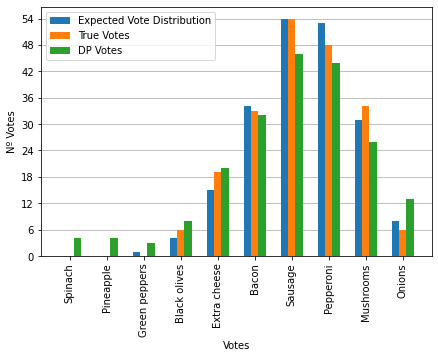

In [21]:

# Set the parameters for the binomial distribution
n = 9  # Number of trials
p = 0.7  # Probability of success

description = "Favorite Pizza Topping"
nvotes = num_votes(description)

expected_distribution = calculate_values_binomial(n, p, nvotes)
true_distribution, noisy_distribution = calculate_discrete_vote_distribution(description, n)

gen_bars_discrete_poll(description, expected_distribution, true_distribution, noisy_distribution)

### Annual Income Bracket Poll

[52 80 49 16  3  0  0]
[50 67 56 20  7  0  0]
[43 53 52 19 14 10  9]


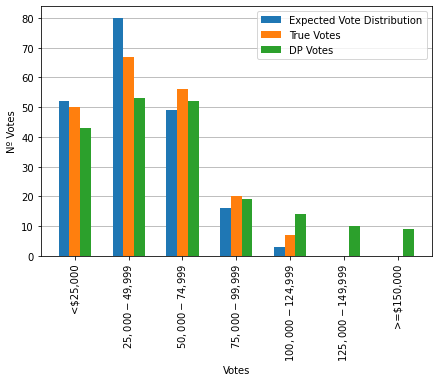

In [22]:

# Set the parameters for the binomial distribution
n = 6  # Number of trials
p = 0.2  # Probability of success

description = "Annual Income Bracket"
nvotes = num_votes(description)

expected_distribution = calculate_values_binomial(n, p, nvotes)
true_distribution, noisy_distribution = calculate_discrete_vote_distribution(description, n)

gen_bars_discrete_poll(description, expected_distribution, true_distribution, noisy_distribution)

### Final Grade in CSD Poll

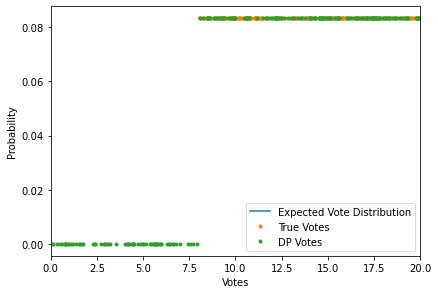

In [23]:
min = 0.0
max = 20.0
a = 8.0
b = 20.0
description = "Final Grade in CSD"

nvotes = num_votes(description)
x = range(nvotes)

expected_distribution = distribution_line_uniform(a, b)
true_distribution = list(map(lambda r: float(r["trueVoteValue"]),filter(lambda r: r["metric"] == "poll_vote" and descriptions[r["pollId"]] == description, clients_metrics)))
noisy_distribution = list(map(lambda r: float(r["noisyVoteValue"]),filter(lambda r: r["metric"] == "poll_vote" and descriptions[r["pollId"]] == description, clients_metrics)))

# print(expected_distribution)
# print(true_distribution)
plt.plot(expected_distribution, list(map(lambda x: pdf_uniform(x, a, b), expected_distribution)), label="Expected Vote Distribution", linestyle="-", marker="")
plt.plot(true_distribution, list(map(lambda x: pdf_uniform(x, a, b), true_distribution)), label="True Votes", linestyle="", marker=".")
plt.plot(noisy_distribution, list(map(lambda x: pdf_uniform(x, a, b), noisy_distribution)), label="DP Votes", linestyle="", marker=".")

plt.xlim(min, max)
plt.legend()
plt.tight_layout()
plt.xlabel("Votes")
#plt.xticks(x + bar_width/2, x_labels, rotation=90)
plt.ylabel('Probability')
#plt.gca().get_yaxis().set_major_locator(plt.MaxNLocator(integer=True))
plt.show()


### Satisfaction Level with Current Job at NOVA SST Poll

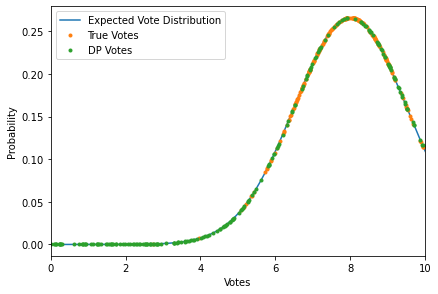

In [24]:
min = 0.0
max = 10.0
mean = 8.0
std = 1.5
description = "Satisfaction Level with Current Job at NOVA SST"

nvotes = num_votes(description)
x = range(nvotes)

expected_distribution = distribution_line_normal(a, b)
true_distribution = sorted(list(map(lambda r: float(r["trueVoteValue"]),filter(lambda r: r["metric"] == "poll_vote" and descriptions[r["pollId"]] == description, clients_metrics))))
noisy_distribution = sorted(list(map(lambda r: float(r["noisyVoteValue"]),filter(lambda r: r["metric"] == "poll_vote" and descriptions[r["pollId"]] == description, clients_metrics))))
# print(expected_distribution)
# print(true_distribution)
plt.plot(expected_distribution, list(map(lambda x: pdf_normal(x,mean,std), expected_distribution)), label="Expected Vote Distribution", linestyle="-", marker="")
plt.plot(true_distribution, list(map(lambda x: pdf_normal(x,mean,std), true_distribution)), label="True Votes", linestyle="", marker=".")
plt.plot(noisy_distribution, list(map(lambda x: pdf_normal(x,mean,std), noisy_distribution)), label="DP Votes", linestyle="", marker=".")
plt.xlim(min, max)
plt.legend()
plt.tight_layout()
plt.xlabel("Votes")
#plt.xticks(x + bar_width/2, x_labels, rotation=90)
plt.ylabel('Probability')
#plt.gca().get_yaxis().set_major_locator(plt.MaxNLocator(integer=True))
plt.show()
